In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, StandardScaler
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Add, Activation, Lambda, Concatenate, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import ModelCheckpoint
from keras import backend
import pickle

In [31]:
path = '..'
df = pd.read_csv(path + '/recommender.csv')

In [4]:
#df = df.drop_duplicates()

In [6]:
#df.to_csv('../recommender.csv', index=False)

In [32]:
df.head()

,review_score,price,customer_state,order_status,seller_state,order_item_id,product_category_name_english,customer_unique_id,order_purchase_timestamp,geolocation_lat,geolocation_lng,product_id
0,4,29.99,SP,delivered,SP,1,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,-23.680114,-46.452454,87285b34884572647811a353c7ac498a
1,4,29.99,SP,delivered,SP,1,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,-23.675223,-46.441038,87285b34884572647811a353c7ac498a
2,4,29.99,SP,delivered,SP,1,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,-23.685712,-46.444796,87285b34884572647811a353c7ac498a
3,4,29.99,SP,delivered,SP,1,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,-23.679951,-46.448247,87285b34884572647811a353c7ac498a
4,4,29.99,SP,delivered,SP,1,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,-23.678662,-46.442578,87285b34884572647811a353c7ac498a


In [33]:
df = df.loc[:,'product_category_name_english,price,seller_state,customer_unique_id,product_id,review_score,order_purchase_timestamp'.split(',')].drop_duplicates()

In [34]:
def binarize_ratings(rating):
    if rating == 5:
        return 1
    else:
        return 0

In [35]:
df['rating'] = df['review_score'].apply(binarize_ratings)

In [36]:
df.rating.value_counts()

1    57706
0    43211
Name: rating, dtype: int64

In [37]:
df.head()

,product_category_name_english,price,seller_state,customer_unique_id,product_id,review_score,order_purchase_timestamp,rating
0,housewares,29.99,SP,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,4,2017-10-02 10:56:33,0
175,housewares,29.99,SP,3a51803cc0d012c3b5dc8b7528cb05f7,87285b34884572647811a353c7ac498a,4,2017-08-15 18:29:31,0
350,housewares,29.99,SP,ef0996a1a279c26e7ecbd737be23d235,87285b34884572647811a353c7ac498a,5,2017-08-02 18:24:47,1
525,housewares,29.99,SP,e781fdcc107d13d865fc7698711cc572,87285b34884572647811a353c7ac498a,3,2017-10-23 23:26:46,0
700,housewares,46.80,SP,7a1de9bde89aedca8c5fbad489c5571c,be03d93320192443b8fa24c0ca6ead98,1,2017-08-24 11:31:28,0


In [42]:
def encode_columns(df, columns_encoded, columns_to_enc):
    encoders = dict()
    uniques = dict()
    for col_enc, col2enc in zip (columns_encoded, columns_to_enc):
        enc = LabelEncoder()
        df[col_enc] = enc.fit_transform(df[col2enc].values)
        n = df[col_enc].nunique() # to be corrected, nunique
        encoders[col_enc] = enc
        uniques[col_enc] = n
    return df, uniques, encoders

In [43]:
df_enc, unique_numbers, encoders = encode_columns(df, 'category,state,customer,product'.split(','), 'product_category_name_english,seller_state,customer_unique_id,product_id'.split(','))

In [44]:
unique_numbers

{'category': 71, 'state': 23, 'customer': 93885, 'product': 32267}

In [45]:
encoders

{'category': LabelEncoder(),
 'state': LabelEncoder(),
 'customer': LabelEncoder(),
 'product': LabelEncoder()}

In [46]:
df_enc

,product_category_name_english,price,seller_state,customer_unique_id,product_id,review_score,order_purchase_timestamp,rating,category,state,customer,product
0,housewares,29.99,SP,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,4,2017-10-02 10:56:33,0,49,22,45665,17076
175,housewares,29.99,SP,3a51803cc0d012c3b5dc8b7528cb05f7,87285b34884572647811a353c7ac498a,4,2017-08-15 18:29:31,0,49,22,21482,17076
350,housewares,29.99,SP,ef0996a1a279c26e7ecbd737be23d235,87285b34884572647811a353c7ac498a,5,2017-08-02 18:24:47,1,49,22,87743,17076
525,housewares,29.99,SP,e781fdcc107d13d865fc7698711cc572,87285b34884572647811a353c7ac498a,3,2017-10-23 23:26:46,0,49,22,85045,17076
700,housewares,46.80,SP,7a1de9bde89aedca8c5fbad489c5571c,be03d93320192443b8fa24c0ca6ead98,1,2017-08-24 11:31:28,0,49,22,44869,23910
...,...,...,...,...,...,...,...,...,...,...,...,...
11840538,diapers_and_hygiene,38.00,SP,8acb1258c5469e79f1fb80009d33d953,f83fd2b539bc73678c65be8d418be8c1,1,2017-12-06 14:04:08,0,23,22,50920,31300
11840626,diapers_and_hygiene,38.00,SP,00ca7e6a87ceddccce3ff015000be61b,f83fd2b539bc73678c65be8d418be8c1,1,2018-03-19 22:33:16,0,23,22,303,31300
11840670,diapers_and_hygiene,45.00,SP,c6c805ba1449708b259b6da9375318ec,5a92ef8a5a2511f0d2dff3ea562700ab,5,2018-04-28 02:23:24,1,23,22,72994,11513
11840714,diapers_and_hygiene,139.89,SC,7e3b6916cdc9629811177f17f7ab07ce,53e695484b71a194bf7d89b48700756a,5,2018-08-26 14:17:08,1,23,20,46428,10667


In [47]:
df_enc.to_csv('../DL_preprocessed/recommender_with_encoded.csv')

In [49]:
df_enc.rename(columns={'order_purchase_timestamp': 'timestamp'}, inplace=True)

<AxesSubplot:>

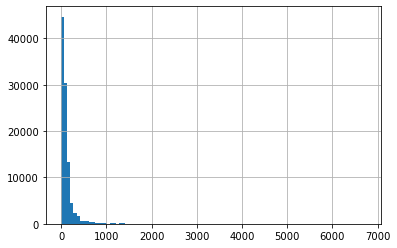

In [51]:
df_enc.price.hist(bins=100)

In [56]:
price_scaler = StandardScaler()
df_enc['scaled_price'] = price_scaler.fit_transform(df_enc.price.values.reshape(-1,1))

In [71]:
df_enc = df_enc.loc[:,'timestamp,category,state,customer,product,scaled_price,rating'.split(',')]

In [72]:
df_enc.to_csv('recommender_encoded.csv')

In [73]:
df_enc.customer.value_counts()

51762    15
22936    13
10119     9
74369     9
19874     8
         ..
63497     1
61448     1
34823     1
32774     1
2047      1
Name: customer, Length: 93885, dtype: int64

In [74]:
df_no_cold = df_enc[df_enc.groupby('customer').customer.transform('count')>1].copy()

In [75]:
df_no_cold.customer.value_counts()

51762    15
22936    13
74369     9
10119     9
39170     8
         ..
50954     2
61191     2
57089     2
55040     2
42975     2
Name: customer, Length: 5664, dtype: int64

In [76]:
len(df_enc)

100917

In [77]:
len(df_no_cold)

12696

In [78]:
df_no_cold

,timestamp,category,state,customer,product,scaled_price,rating
0,2017-10-02 10:56:33,49,22,45665,17076,-0.501005,0
700,2017-08-24 11:31:28,49,22,44869,23910,-0.411884,0
5075,2017-08-05 14:52:23,49,22,2937,1466,-0.533291,1
17885,2017-05-20 15:56:32,49,8,15170,7538,0.134714,1
23537,2017-09-30 14:48:37,49,22,42130,27460,-0.342433,1
...,...,...,...,...,...,...,...
11835125,2018-06-12 15:58:03,13,22,2712,18910,-0.253630,0
11835992,2018-05-15 17:33:50,13,22,62110,29436,-0.395979,1
11837125,2018-06-12 15:58:03,13,22,2712,14713,-0.008430,0
11840098,2018-03-26 03:50:48,23,22,50530,8153,-0.527460,0


In [79]:
df_test = df_no_cold.sort_values('timestamp', ascending=False).groupby(['customer']).head(1)

In [80]:
df_test.to_csv('../DL_preprocessed/test.csv')

In [81]:
df_train = df_no_cold[~df_no_cold.index.isin(df_test.index)]

In [82]:
df_train.to_csv('../DL_preprocessed/train.csv')

In [84]:
pickle.dump(encoders, open('../DL_preprocessed/encoders.sav', 'wb'))

In [85]:
pickle.dump(unique_numbers, open('../DL_preprocessed/unique_counts.sav', 'wb'))

In [86]:
n_factors = 10

In [ ]:

model = RecommenderNet(n_customers+1, n_items+1, n_factors, 0, 1, 1)
history = model.fit(x=X_train, y=y_train, batch_size=512, epochs=100,
                    verbose=1, validation_data=(X_test, y_test))